<a href="https://colab.research.google.com/github/mmcdermott/AUC_is_all_you_need/blob/main/AUROC_AUPRC_equivalencies_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U scikit-learn
!pip install netcal
!pip install -U kaleido
# !pip install pyprg
# `pyprg` does not work with this module of numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires p

In [ ]:
import itertools
import colorsys
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import tqdm
import warnings

from collections import defaultdict
from functools import partial
from plotly.subplots import make_subplots
from scipy.stats import binom, spearmanr, pearsonr, NearConstantInputWarning, ConstantInputWarning
from sklearn.metrics import (
    auc, average_precision_score, roc_auc_score, roc_curve, precision_score,
    recall_score
)
from tqdm.auto import tqdm
from typing import Callable
from multiprocessing import cpu_count, Pool


from sklearn.calibration import CalibratedClassifierCV,  _SigmoidCalibration, _sigmoid_calibration
from sklearn.isotonic import IsotonicRegression
from netcal.metrics import ECE

N_CPUs = cpu_count()

## PRG

In [ ]:
""" Software to create Precision-Recall-Gain curves.
Precision-Recall-Gain curves and how to cite this work is available at
http://www.cs.bris.ac.uk/~flach/PRGcurves/.

This is the original implementation from
https://github.com/meeliskull/prg/blob/master/Python_package/prg/prg.py
except for some minor bugfixes by me (Eike Petersen, 2023).
"""

import warnings
import numpy as np
import matplotlib.pyplot as plt


def alen(x):
    return 1 if np.isscalar(x) else len(x)


def precision(tp, fn, fp, tn):
    with np.errstate(divide='ignore', invalid='ignore'):
        return tp/(tp + fp)


def recall(tp, fn, fp, tn):
    with np.errstate(divide='ignore', invalid='ignore'):
        return tp/(tp + fn)


def precision_gain(tp, fn, fp, tn):
    """Calculates Precision Gain from the contingency table
    This function calculates Precision Gain from the entries of the contingency
    table: number of true positives (TP), false negatives (FN), false positives
    (FP), and true negatives (TN). More information on Precision-Recall-Gain
    curves and how to cite this work is available at
    http://www.cs.bris.ac.uk/~flach/PRGcurves/.
    """
    n_pos = tp + fn
    n_neg = fp + tn
    with np.errstate(divide='ignore', invalid='ignore'):
        prec_gain = 1. - (n_pos/n_neg) * (fp/tp)
    if alen(prec_gain) > 1:
        prec_gain[tn + fn == 0] = 0
    elif tn + fn == 0:
        prec_gain = 0
    return prec_gain


def recall_gain(tp, fn, fp, tn):
    """Calculates Recall Gain from the contingency table
    This function calculates Recall Gain from the entries of the contingency
    table: number of true positives (TP), false negatives (FN), false positives
    (FP), and true negatives (TN). More information on Precision-Recall-Gain
    curves and how to cite this work is available at
    http://www.cs.bris.ac.uk/~flach/PRGcurves/.
    Args:
        tp (float) or ([float]): True Positives
        fn (float) or ([float]): False Negatives
        fp (float) or ([float]): False Positives
        tn (float) or ([float]): True Negatives
    Returns:
        (float) or ([float])
    """
    n_pos = tp + fn
    n_neg = fp + tn
    with np.errstate(divide='ignore', invalid='ignore'):
        rg = 1. - (n_pos/n_neg) * (fn/tp)
    if alen(rg) > 1:
        rg[tn + fn == 0] = 1
    elif tn + fn == 0:
        rg = 1
    return rg


def create_segments(labels, pos_scores, neg_scores):
    n = alen(labels)
    # reorder labels and pos_scores by decreasing pos_scores, using increasing neg_scores in breaking ties
    new_order = np.lexsort((neg_scores, -pos_scores))
    labels = labels[new_order]
    pos_scores = pos_scores[new_order]
    neg_scores = neg_scores[new_order]
    # create a table of segments
    segments = {'pos_score': np.zeros(n), 'neg_score': np.zeros(n),
                'pos_count': np.zeros(n), 'neg_count': np.zeros(n)}
    j = -1
    for i, label in enumerate(labels):
        if ((i == 0) or (pos_scores[i-1] != pos_scores[i])
                     or (neg_scores[i-1] != neg_scores[i])):
            j += 1
            segments['pos_score'][j] = pos_scores[i]
            segments['neg_score'][j] = neg_scores[i]
        if label == 0:
            segments['neg_count'][j] += 1
        else:
            segments['pos_count'][j] += 1
    segments['pos_score'] = segments['pos_score'][0:j+1]
    segments['neg_score'] = segments['neg_score'][0:j+1]
    segments['pos_count'] = segments['pos_count'][0:j+1]
    segments['neg_count'] = segments['neg_count'][0:j+1]
    return segments


def get_point(points, index):
    keys = points.keys()
    point = np.zeros(alen(keys))
    key_indices = dict()
    for i, key in enumerate(keys):
        point[i] = points[key][index]
        key_indices[key] = i
    return [point, key_indices]


def insert_point(new_point, key_indices, points, precision_gain=0, recall_gain=0, is_crossing=0):
    for key in key_indices.keys():
        points[key] = np.insert(points[key], 0, new_point[key_indices[key]])
    points['precision_gain'][0] = precision_gain
    points['recall_gain'][0] = recall_gain
    points['is_crossing'][0] = is_crossing
    new_order = np.lexsort((-points['precision_gain'],points['recall_gain']))
    for key in points.keys():
        points[key] = points[key][new_order]
    return points


def _create_crossing_points(points, n_pos, n_neg):
    n = n_pos+n_neg
    points['is_crossing'] = np.zeros(alen(points['pos_score']))
    # introduce a crossing point at the crossing through the y-axis
    j = np.amin(np.where(points['recall_gain'] >= 0)[0])
    if points['recall_gain'][j] > 0:  # otherwise there is a point on the boundary and no need for a crossing point
        [point_1, key_indices_1] = get_point(points, j)
        [point_2, key_indices_2] = get_point(points, j-1)
        delta = point_1 - point_2
        if delta[key_indices_1['TP']] > 0:
            alpha = (n_pos*n_pos/n - points['TP'][j-1]) / delta[key_indices_1['TP']]
        else:
            alpha = 0.5

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            new_point = point_2 + alpha*delta

        new_prec_gain = precision_gain(new_point[key_indices_1['TP']], new_point[key_indices_1['FN']],
                                       new_point[key_indices_1['FP']], new_point[key_indices_1['TN']])
        points = insert_point(new_point, key_indices_1, points,
                              precision_gain=new_prec_gain, is_crossing=1)

    # now introduce crossing points at the crossings through the non-negative part of the x-axis
    x = points['recall_gain']
    y = points['precision_gain']
    temp_y_0 = np.append(y, 0)
    temp_0_y = np.append(0, y)
    temp_1_x = np.append(1, x)

    with np.errstate(invalid='ignore'):
        indices = np.where(np.logical_and((temp_y_0 * temp_0_y < 0), (temp_1_x >= 0)))[0]
    for i in indices:
        cross_x = x[i-1] + (-y[i-1]) / (y[i] - y[i-1]) * (x[i] - x[i-1])
        [point_1, key_indices_1] = get_point(points, i)
        [point_2, key_indices_2] = get_point(points, i-1)
        delta = point_1 - point_2
        if delta[key_indices_1['TP']] > 0:
            alpha = (n_pos * n_pos / (n - n_neg * cross_x) - points['TP'][i-1]) / delta[key_indices_1['TP']]
        else:
            alpha = (n_neg / n_pos * points['TP'][i-1] - points['FP'][i-1]) / delta[key_indices_1['FP']]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            new_point = point_2 + alpha*delta

        new_rec_gain = recall_gain(new_point[key_indices_1['TP']], new_point[key_indices_1['FN']],
                                   new_point[key_indices_1['FP']], new_point[key_indices_1['TN']])
        points = insert_point(new_point, key_indices_1, points,
                              recall_gain=new_rec_gain, is_crossing=1)
        i += 1
        indices += 1
        x = points['recall_gain']
        y = points['precision_gain']
    return points


def create_prg_curve(labels, pos_scores, neg_scores=[]):
    """Precision-Recall-Gain curve
    This function creates the Precision-Recall-Gain curve from the vector of
    labels and vector of scores where higher score indicates a higher
    probability to be positive. More information on Precision-Recall-Gain
    curves and how to cite this work is available at
    http://www.cs.bris.ac.uk/~flach/PRGcurves/.
    """
    create_crossing_points = True  # do it always because calc_auprg otherwise gives the wrong result
    if alen(neg_scores) == 0:
        neg_scores = -pos_scores
    n = alen(labels)
    n_pos = np.sum(labels)
    n_neg = n - n_pos
    # convert negative labels into 0s
    labels = 1 * (labels == 1)
    segments = create_segments(labels, pos_scores, neg_scores)
    # calculate recall gains and precision gains for all thresholds
    points = dict()
    points['pos_score'] = np.insert(segments['pos_score'], 0, np.inf)
    points['neg_score'] = np.insert(segments['neg_score'], 0, -np.inf)
    points['TP'] = np.insert(np.cumsum(segments['pos_count']), 0, 0)
    points['FP'] = np.insert(np.cumsum(segments['neg_count']), 0, 0)
    points['FN'] = n_pos - points['TP']
    points['TN'] = n_neg - points['FP']
    points['precision'] = precision(points['TP'], points['FN'], points['FP'], points['TN'])
    points['recall'] = recall(points['TP'], points['FN'], points['FP'], points['TN'])
    points['precision_gain'] = precision_gain(points['TP'], points['FN'], points['FP'], points['TN'])
    points['recall_gain'] = recall_gain(points['TP'], points['FN'], points['FP'], points['TN'])
    if create_crossing_points == True:
        points = _create_crossing_points(points, n_pos, n_neg)
    else:
        points['pos_score'] = points['pos_score'][1:]
        points['neg_score'] = points['neg_score'][1:]
        points['TP'] = points['TP'][1:]
        points['FP'] = points['FP'][1:]
        points['FN'] = points['FN'][1:]
        points['TN'] = points['TN'][1:]
        points['precision_gain'] = points['precision_gain'][1:]
        points['recall_gain'] = points['recall_gain'][1:]

    with np.errstate(invalid='ignore'):
        points['in_unit_square'] = np.logical_and(points['recall_gain'] >= 0,
                                                  points['precision_gain'] >= 0)

    return points


def calc_auprg_from_data(y, yhat):
    return calc_auprg(create_prg_curve(y, yhat))


def calc_auprg(prg_curve):
    """Calculate area under the Precision-Recall-Gain curve
    This function calculates the area under the Precision-Recall-Gain curve
    from the results of the function create_prg_curve. More information on
    Precision-Recall-Gain curves and how to cite this work is available at
    http://www.cs.bris.ac.uk/~flach/PRGcurves/.
    """
    area = 0
    recall_gain = prg_curve['recall_gain']
    precision_gain = prg_curve['precision_gain']
    for i in range(1, len(recall_gain)):
        if (not np.isnan(recall_gain[i-1])) and (recall_gain[i-1] >= 0):
            width = recall_gain[i] - recall_gain[i-1]
            height = (precision_gain[i] + precision_gain[i-1]) / 2
            area += width*height
    return area


def convex_hull(points):
    """Computes the convex hull of a set of 2D points.
    Input: an iterable sequence of (x, y) pairs representing the points.
    Output: a list of vertices of the convex hull in counter-clockwise order,
      starting from the vertex with the lexicographically smallest coordinates.
    Implements Andrew's monotone chain algorithm. O(n log n) complexity.
    Source code from:
    https://en.wikibooks.org/wiki/Algorithm_Implementation/Geometry/Convex_hull/Monotone_chain
    """

    # Sort the points lexicographically (tuples are compared lexicographically).
    # Remove duplicates to detect the case we have just one unique point.
    points = sorted(set(points))

    # Boring case: no points or a single point, possibly repeated multiple times.
    if len(points) <= 1:
        return points

    # 2D cross product of OA and OB vectors, i.e. z-component of their 3D cross product.
    # Returns a positive value, if OAB makes a counter-clockwise turn,
    # negative for clockwise turn, and zero if the points are collinear.
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    return upper

# Validating Theoretical Relationships Between AUROC and AUPRC
Claims:
1. $\mathrm{AUROC}_{\boldsymbol \theta} = 1 - \mathbb{E}_{p_+}[\mathrm{FPR}]$, and $\mathrm{AUPRC}_{\boldsymbol \theta} = 1 - P_{\mathsf y}(y = 0)\mathbb{E}_{p_+}\left[\frac{\mathrm{FPR}}{P_{\mathsf p}(p > p_+)}\right]$
2. That #1 implies that AUROC favors all local swaps from incorrect ordered neighbors to correctly ordered neighbors equally, but AUPRC favors them in inverse correlation with model hit rate
2. When there is a high prevalence of positive labels, then $\mathrm{AUPRC} \approx 1 + \frac{P_{\mathsf y}(y=0)}{P_{\mathsf y}(y=1)} \mathrm{AU(log)ROC}$

## Utility Functions

In [ ]:
def sample_at_AUROC(
    N: int, target_AUROC: float, pos_prev: float, seed: int = 1,
    normalize_score_to_prevalence = False,
    calibrate = True,
    calibration_method = 'platt'
) -> tuple[np.ndarray, np.ndarray]:
  """This function samples probabilities and binary labels at the given AUROC

  Args:
      N: The number of samples to return
      target_AUROC: The desired AUROC the resulting probabilities and labels
          should display.
      pos_prev: The prevalence of the positive label.
      seed: The random seed that should be used.
  """

  if N <= 0:
    raise ValueError(f"N must be a positive int; got {N}")
  if target_AUROC < 0 or target_AUROC > 1:
    raise ValueError(f"target_AUROC must be in [0, 1]; got {target_AUROC}")
  if pos_prev <= 0 or pos_prev >= 1:
    raise ValueError(f"pos_prev must be in (0, 1); got {pos_prev}")

  rng = np.random.default_rng(seed)

  N_true = int(round((pos_prev * N)))
  N_false = N - N_true

  if N_true == 0 or N_false == 0:
    raise ValueError(f"pos_prev is too extreme; got {N_true} and {N_false}")

  pos_scores = list(sorted(rng.uniform(low=0, high=1, size=N_true)))

  bounds = [0] + pos_scores
  neg_score_window_probs = []
  for n_pos_lt, lb in enumerate(bounds):
    # probability that a negative sample is > n_pos_lt is (1-AUC)**n_pos_lt
    neg_score_window_probs.append(binom.pmf(n_pos_lt, N_true, 1-target_AUROC))

  neg_scores = []
  for _ in range(N_false):
    window = rng.choice(len(bounds), p=neg_score_window_probs, size=1).item()
    window = int(window)
    lb = bounds[window]
    ub = (bounds + [1])[window+1]
    neg_scores.append(rng.uniform(low=lb, high=ub, size=1).item())

  scores = np.concatenate((pos_scores, neg_scores))
  Ys = np.array([True] * N_true + [False] * N_false)

  if normalize_score_to_prevalence:
    scores = scores / scores.mean() * pos_prev

  if calibrate:
    if calibration_method == 'isotonic':
        clf = IsotonicRegression().fit(scores, Ys)
        scores = clf.transform(scores)
    elif calibration_method == 'platt':
        clf = _SigmoidCalibration().fit(scores, Ys)
        scores = clf.predict(scores)

  return scores, Ys

## Theorem 1
$\mathrm{AUROC}_{\boldsymbol \theta} = 1 - \mathbb{E}_{p_+}[\mathrm{FPR}]$, and $\mathrm{AUPRC}_{\boldsymbol \theta} = 1 - P_{\mathsf y}(y = 0)\mathbb{E}_{p_+}\left[\frac{\mathrm{FPR}}{P_{\mathsf p}(p > p_+)}\right]$

### Main Theorem

In [ ]:
def expectation_based_AUROC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUROC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  sorted_idx = np.argsort(probs)
  labels = labels[sorted_idx]

  N_neg = (labels == 0).sum()
  pos_idx = np.argwhere(labels == 1)

  n_FPs = (labels == 0)[::-1].cumsum()[::-1]
  FPRs = n_FPs / N_neg

  exp = FPRs[pos_idx].mean()
  return 1 - exp

def expectation_based_AUPRC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUPRC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  sorted_idx = np.argsort(probs)
  labels = labels[sorted_idx]

  N = len(labels)
  N_neg = (labels == 0).sum()
  pos_idx = np.argwhere(labels == 1)

  n_FPs = (labels == 0)[::-1].cumsum()[::-1]
  FPRs = n_FPs / N_neg

  firing_rates = np.ones_like(probs)[::-1].cumsum()[::-1]/N

  weighted_FPRs = FPRs/firing_rates

  exp = weighted_FPRs[pos_idx].mean()
  return 1 - (N_neg/N)*exp

In [ ]:
N_seeds = 5
grid_size = 50
N_samples = 1000

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    out["AUROC/target"].append(AUROC)
    out["prev"].append(prev)
    out["seed"].append(seed)

    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    out["AUROC/sklearn"].append(roc_auc_score(Ys, probs))
    out["AUROC/theory"].append(expectation_based_AUROC(Ys, probs))
    out["AUPRC/sklearn"].append(average_precision_score(Ys, probs))
    out["AUPRC/theory"].append(expectation_based_AUPRC(Ys, probs))

out = pd.DataFrame(out)

pd.DataFrame({
    'AUROC/summ': (out['AUROC/sklearn']).describe(),
    'AUPRC/summ': (out['AUPRC/sklearn']).describe(),
    'AUROC/delta': (out['AUROC/sklearn'] - out['AUROC/theory']).describe(),
    'AUPRC/delta': (out['AUPRC/sklearn'] - out['AUPRC/theory']).describe(),
})

  0%|          | 0/2500 [00:00<?, ?it/s]

,AUROC/summ,AUPRC/summ,AUROC/delta,AUPRC/delta
count,12500.000000,12500.000000,1.250000e+04,1.250000e+04
mean,0.744869,0.844923,2.930989e-19,-3.002043e-18
std,0.141781,0.138246,8.067856e-17,7.310829e-17
min,0.448811,0.183873,-3.330669e-16,-3.330669e-16
25%,0.626494,0.768955,0.000000e+00,0.000000e+00
50%,0.745107,0.885114,0.000000e+00,0.000000e+00
75%,0.863411,0.955609,0.000000e+00,0.000000e+00
max,0.981735,0.999631,3.330669e-16,3.330669e-16


### Lemma 1.1: AUROC improves with all mistakes equally, AUPRC favors higher scored predictions


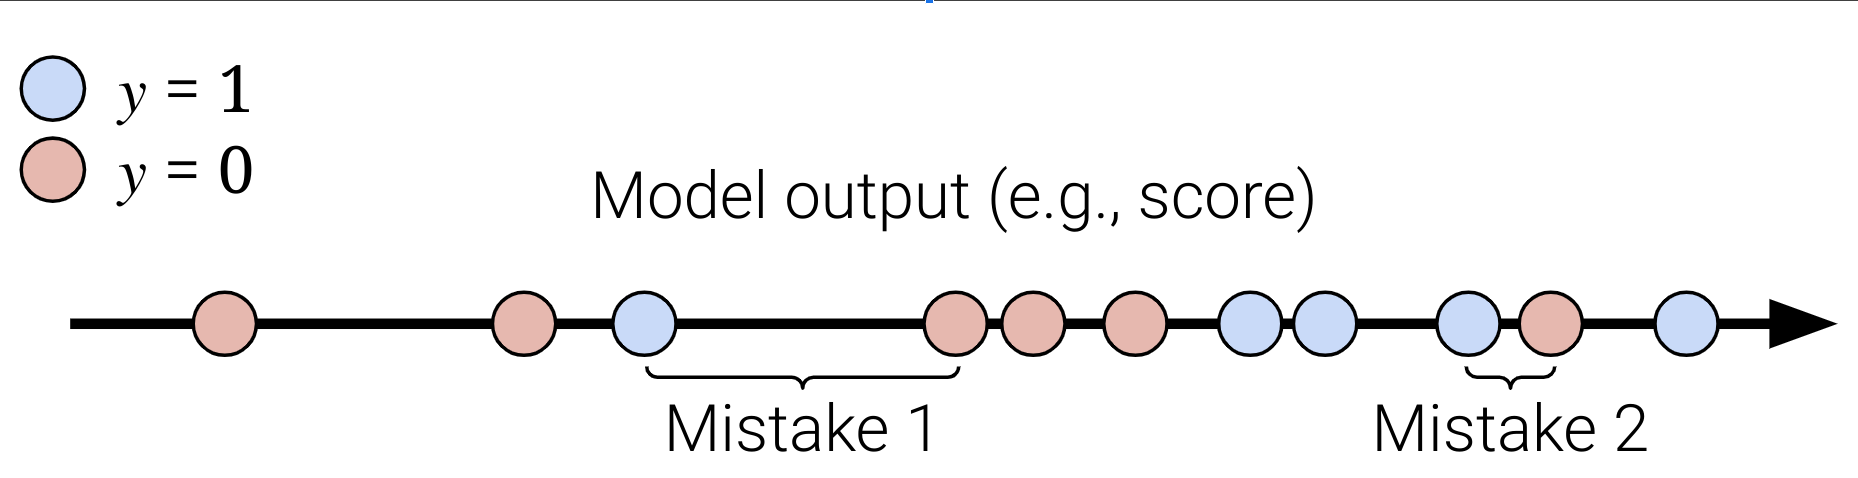



In [ ]:
N_seeds = 4
min_N_pairs = 10
grid_size = 20
N_samples = 250

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
summary_out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    sort_idx = np.argsort(probs)
    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pairs = []
    for i in range(N_samples - 1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pairs.append((i, i + 1))

    if len(pairs) < min_N_pairs:
      continue

    L = len(out["AUROC/orig"])

    for i, j in pairs:
      out["AUROC/orig"].append(AUROC)
      out["AUPRC/orig"].append(average_precision_score(Ys, probs))
      out["prev"].append(prev)
      out["seed"].append(seed)
      out["pair_prob"].append(probs[i])
      out["pair_firing_rate"].append((N_samples - j)/N_samples)


      pi = probs[i]
      pj = probs[j]
      probs_if_fixed = probs.copy()
      probs_if_fixed[i] = pj
      probs_if_fixed[j] = pi

      out["AUROC/mistake_fixed"].append(roc_auc_score(Ys, probs_if_fixed))
      out["AUPRC/mistake_fixed"].append(average_precision_score(Ys, probs_if_fixed))

    summary_out["AUROC/orig"].append(AUROC)
    summary_out["AUPRC/orig"].append(average_precision_score(Ys, probs))
    summary_out["prev"].append(prev)
    summary_out["seed"].append(seed)

    aurocs = np.array(out["AUROC/mistake_fixed"][L:]).round(5)
    auprcs = np.array(out["AUPRC/mistake_fixed"][L:]).round(5)
    probs = np.array(out["pair_prob"][L:])
    firing_rates = np.array(out["pair_firing_rate"][L:])

    summary_out["AUROC/delta_fixed"].append(max(aurocs) - min(aurocs))
    summary_out["AUPRC/delta_fixed"].append(max(auprcs) - min(auprcs))

    with warnings.catch_warnings():
      warnings.simplefilter('ignore', NearConstantInputWarning)
      warnings.simplefilter('ignore', ConstantInputWarning)

      spearman_coeff, spearman_p = spearmanr(1/firing_rates, auprcs)
      summary_out["AUPRC_v_firing_rates/spearmanr/p"].append(spearman_p)
      summary_out["AUPRC_v_firing_rates/spearmanr/coeff"].append(spearman_coeff)

      pearson_coeff, pearson_p = pearsonr(1/firing_rates, auprcs)
      summary_out["AUPRC_v_firing_rates/pearsonr/p"].append(pearson_p)
      summary_out["AUPRC_v_firing_rates/pearsonr/coeff"].append(pearson_coeff)

      spearman_coeff, spearman_p = spearmanr(1/firing_rates, aurocs)
      summary_out["AUROC_v_firing_rates/spearmanr/p"].append(spearman_p)
      summary_out["AUROC_v_firing_rates/spearmanr/coeff"].append(spearman_coeff)

      pearson_coeff, pearson_p = pearsonr(1/firing_rates, aurocs)
      summary_out["AUROC_v_firing_rates/pearsonr/p"].append(pearson_p)
      summary_out["AUROC_v_firing_rates/pearsonr/coeff"].append(pearson_coeff)


out = pd.DataFrame(out)
summary_out = pd.DataFrame(summary_out)

summary_description = summary_out[[c for c in summary_out.columns if c.startswith("AU")]].describe()

count = summary_description["AUROC/orig"]["count"]
auroc_max_delta = summary_description["AUROC/delta_fixed"]["max"]
auroc_min_p = min(
  summary_description["AUROC_v_firing_rates/pearsonr/p"]["min"],
  summary_description["AUROC_v_firing_rates/spearmanr/p"]["min"]
)

auprc_max_delta = summary_description["AUPRC/delta_fixed"]["max"]
auprc_min_p = min(
  summary_description["AUPRC_v_firing_rates/pearsonr/p"]["min"],
  summary_description["AUPRC_v_firing_rates/spearmanr/p"]["min"]
)
auprc_max_p = max(
  summary_description["AUPRC_v_firing_rates/pearsonr/p"]["max"],
  summary_description["AUPRC_v_firing_rates/spearmanr/p"]["max"]
)

print(
    f"Across {int(count)} trials, "
    "the maximum discrepancy between the AUROC upon "
    f"fixing a mistake is {auroc_max_delta:.1e} and the minimum correlation "
    f"$p$-value is {auroc_min_p:.1f}.\n"
    "The maximum discrepancy between the AUPRC upon "
    f"fixing a mistake is {auprc_max_delta:.1f} and the correlation "
    f"$p$-value is in [{auprc_min_p:.1f}-{auprc_max_p:.1e}]."
)

  0%|          | 0/400 [00:00<?, ?it/s]

Across 1442 trials, the maximum discrepancy between the AUROC upon fixing a mistake is 0.0e+00 and the minimum correlation $p$-value is nan.
The maximum discrepancy between the AUPRC upon fixing a mistake is 0.0 and the correlation $p$-value is in [0.0-1.4e-01].


In [ ]:
for_pivot_plot = summary_out.copy()
for_pivot_plot["AUPRC_v_firing_rates/spearmanr/p"] = np.log(for_pivot_plot["AUPRC_v_firing_rates/spearmanr/p"])
px.imshow(
    pd.pivot_table(for_pivot_plot, index="AUROC/orig", columns="prev", values="AUPRC_v_firing_rates/spearmanr/p", aggfunc=max)
)

### Lemma 1.2: Optimizing for AUPRC excacerbates disparities between groups with different prevalences

Suppose we have two subpopulations, $X_1$ and $X_2$, such that the prevalence of the positive label differs between $X_1$ and $X_2$.

In [ ]:
def fix_mistake_by_AUPRC(Ys: np.ndarray, probs: np.ndarray, *args, **kwargs) -> np.ndarray:
    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)

    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pair = None
    for i in range(len(Ys)-2, 0, -1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pair = (i, i+1)
      break

    if pair is None: return probs[unsort_idx]

    i, j = pair
    probs_if_fixed = probs.copy()
    pi = probs_if_fixed[i]
    pj = probs_if_fixed[j]
    probs_if_fixed[i] = pj
    probs_if_fixed[j] = pi

    return probs_if_fixed[unsort_idx]

def fix_mistake_by_AUROC(Ys: np.ndarray, probs: np.ndarray, *args, **kwargs) -> np.ndarray:
    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)

    probs = probs[sort_idx]
    Ys = Ys[sort_idx]

    # Find pairs of indices with neighboring probabilities and misaligned labels and probabilities
    pairs = []
    for i in range(len(Ys)-2, 0, -1):
      if probs[i] == probs[i + 1]:
        continue
      if Ys[i] <= Ys[i + 1]:
        continue
      pairs.append((i, i+1))

    if not pairs: return probs[unsort_idx]

    pair = pairs[np.random.choice(len(pairs))]

    i, j = pair
    probs_if_fixed = probs.copy()
    pi = probs_if_fixed[i]
    pj = probs_if_fixed[j]
    probs_if_fixed[i] = pj
    probs_if_fixed[j] = pi

    return probs_if_fixed[unsort_idx]

def sample_perturbation(lower, upper, N, n_trials, rng):
    if np.isscalar(lower) and np.isscalar(upper): # bounds are simple scalars, just generate the matrix
        return rng.uniform(lower, upper, size = (N, n_trials))
    # convert both bounds to arrays
    if np.isscalar(lower):
        lower = np.ones((N, )) * lower
    if np.isscalar(upper):
        upper = np.ones((N, )) * upper

    return np.vstack([rng.uniform(lower[i], upper[i], size = (1, n_trials)) for i in range(N)])

def auprg_score(Ys, scores):
    return calc_auprg_from_data(Ys, scores)

def random_perturb(Ys: np.ndarray, probs: np.ndarray, step: int, optimize: str = 'AUROC',
                   compute_magnitude_method: str = 'step',
                   magnitude_inc: float = 0.001, magnitude_override: float = 0.01,
                   n_trials: int = 100, directed: bool = False, seed: int = 0) -> np.ndarray:
    '''
    To specify the max magnitude of the perturbation:
        if compute_magnitude_method == 'step', then it is step * magnitude_inc
        if compute_magnitude_method == 'magnitude', it is magnitude_override
        if compute_magnitude_method == 'per_sample', the magnitude for each sample is magnitude_override * min(s, 1-s)
    '''
    rng = np.random.default_rng(seed)
    if compute_magnitude_method == 'step':
        magnitude = magnitude_inc * step
    elif compute_magnitude_method == 'magnitude':
        magnitude = magnitude_override
    elif compute_magnitude_method == 'per_sample':
        magnitude = magnitude_override * np.minimum(probs, 1-probs)
    else:
        raise NotImplementedError(compute_magnitude_method)

    if not directed:
        perturb_mat = sample_perturbation(-magnitude, magnitude, len(Ys), n_trials, rng)
    else:
        perturb_mat = np.zeros((len(Ys), n_trials))
        perturb_mat[Ys == 0, :] = sample_perturbation(-magnitude, 0, len(Ys), n_trials, rng)[Ys == 0, :]
        perturb_mat[Ys == 1, :] = sample_perturbation(0, magnitude, len(Ys), n_trials, rng)[Ys == 1, :]

    if probs.ndim == 1:
        probs = np.expand_dims(probs, -1)

    new_probs = np.clip(probs + perturb_mat, 0, 1)
    if optimize == 'AUROC':
        func = roc_auc_score
    elif optimize == 'AUPRC':
        func = average_precision_score
    elif optimize == 'AUPRG':
        func = auprg_score
    else:
        raise NotImplementedError(optimize)
    mets = np.apply_along_axis(lambda a: func(Ys, a), axis = 0, arr = new_probs)

    return new_probs[:, mets.argmax()]

In [ ]:
def sample_rank_permutation(
    max_per_sample_rank_delta: int, N: int, n_trials: int, rng
) -> np.ndarray:
    """Generates a permutation matrix with no elements above or below a diag.
    """

    permutation_matrices_scores = rng.uniform(low=0, high=1, size=(n_trials, N, N))
    permutation_matrices_scores = np.triu(np.tril(
        permutation_matrices_scores, k=max_per_sample_rank_delta
    ), k=-max_per_sample_rank_delta)
    # permutation matrices now has zeros above and below the appropriate
    # diagonals.

    permutation_matrices = np.zeros_like(permutation_matrices_scores)

    options_per_row = np.sum(
      permutation_matrices_scores != 0, axis=1, keepdims=True
    )
    options_per_col = np.sum(
      permutation_matrices_scores != 0, axis=2, keepdims=True
    )

    for i in range(N):
      # If we have no other options:
      is_omitted = (permutation_matrices_scores == 0)

      idx_must_choose = (
          ((options_per_row == 1) | (options_per_col == 1)) &
          ~is_omitted
      )

      any_must_choose = idx_must_choose.max(axis=(1, 2), keepdims=True)

      idx_is_max = (
          permutation_matrices_scores ==
          permutation_matrices_scores.max(axis=(1, 2), keepdims=True)
      )

      selection_idx = (
          idx_must_choose |
          (idx_is_max & ~any_must_choose & ~is_omitted)
      )

      n_selections = selection_idx.sum(axis=(1, 2))

      selection_in_row = selection_idx.max(axis=1, keepdims=True)
      selection_in_col = selection_idx.max(axis=2, keepdims=True)

      permutation_matrices_scores = np.where(
          (selection_in_row == 1) | (selection_in_col == 1), 0,
          permutation_matrices_scores
      )

      permutation_matrices = np.where(
          selection_idx == 1, 1, permutation_matrices
      )

      options_per_row = np.sum(
        permutation_matrices_scores != 0, axis=1, keepdims=True
      )
      options_per_col = np.sum(
        permutation_matrices_scores != 0, axis=2, keepdims=True
      )


    return permutation_matrices


In [ ]:
def random_rank_perturb(
    Ys: np.ndarray, probs: np.ndarray, optimize: str = 'AUROC',
    max_sample_rank_delta: int = 3, n_trials: int = 100,
    seed: int = 0, **kwargs
) -> np.ndarray:
    ''' Perturbs the scores by randomly re-ordering subject to constraints.
    '''

    sort_idx = np.argsort(probs)
    unsort_idx = np.empty_like(sort_idx)
    unsort_idx[sort_idx] = np.arange(sort_idx.size)


    probs = probs[sort_idx]
    Ys = Ys[sort_idx]
    rng = np.random.default_rng(seed)

    permutation_matrices = sample_rank_permutation(
        max_sample_rank_delta, len(Ys), n_trials, rng
    )
    # permutation_matrices is of shape (n_trials, N, N)

    # probs is of shape (N,)
    permuted_probs = np.expand_dims(
        np.tile(np.expand_dims(probs, 0), (n_trials, 1)), -1
    )
    # permuted_probs is of shape (n_trials, N, 1)

    # actually do the permutations
    permuted_probs = permutation_matrices @ permuted_probs

    if optimize == 'AUROC':
        func = roc_auc_score
    elif optimize == 'AUPRC':
        func = average_precision_score
    elif optimize == 'AUPRG':
        func = auprg_score
    else:
        raise NotImplementedError(f"optimize score {optimize} not supported")

    mets = np.apply_along_axis(
        lambda a: func(Ys, a), axis = 1, arr = permuted_probs
    )

    return permuted_probs[mets.argmax(), :].squeeze(-1)[unsort_idx]

In [ ]:
def check_optimization_drift(
    optimizer_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
    subgroup_1_kwargs: dict[str, float],
    subgroup_2_kwargs: dict[str, float],
    N_steps: int = 50,
    N_seeds: int = 10,
    optimizer_fn_kwargs: dict[str, float] = {},
    override_probs_each_step: bool = True
) -> dict[str, list[float]]:
  opt_fn = partial(
      check_optimization_drift_once,
      optimizer_fn, subgroup_1_kwargs, subgroup_2_kwargs, N_steps,
      optimizer_fn_kwargs=optimizer_fn_kwargs,
      override_probs_each_step=override_probs_each_step,
  )
  with Pool(N_CPUs) as p:
    data_frames = list(tqdm(
        p.imap(opt_fn, range(N_seeds)), desc = "Seeds", leave=False,
        total=N_seeds
    ))

  out_frame = {
      "step": data_frames[0].step.values,
      "Variable": data_frames[0].Variable.values,
  }

  for col in data_frames[0].columns:
    if col in out_frame: continue

    f = pd.DataFrame({i: df[col] for i, df in enumerate(data_frames)})
    out_frame[f"{col}/mean"] = f.mean(axis=1).values
    out_frame[f"{col}/std"] = f.std(axis=1).values
    out_frame[f"{col}/0.05"] = f.quantile(q=0.05, axis=1).values
    out_frame[f"{col}/0.95"] = f.quantile(q=0.95, axis=1).values

  return pd.DataFrame(out_frame)

def check_optimization_drift_once(
    optimizer_fn: Callable[[np.ndarray, np.ndarray], np.ndarray],
    subgroup_1_kwargs: dict[str, float],
    subgroup_2_kwargs: dict[str, float],
    N_steps: int = 50,
    seed: int = 1,
    optimizer_fn_kwargs: dict[str, float] = {},
    override_probs_each_step: bool = True
) -> dict[str, list[float]]:
    np.random.seed(seed)

    probs_1, labels_1 = sample_at_AUROC(**subgroup_1_kwargs, seed=seed)
    probs_2, labels_2 = sample_at_AUROC(**subgroup_2_kwargs, seed=seed)

    probs = np.concatenate((probs_1, probs_2))
    probs_back = np.copy(probs)
    labels = np.concatenate((labels_1, labels_2))
    subgroup_idx = np.concatenate(
        (np.zeros_like(probs_1), np.ones_like(probs_2))
    )

    results = defaultdict(list)
    for step in tqdm(list(range(N_steps)), desc="Steps", leave=False):
      results["step"].append(step)
      results["AUROC/overall"].append(roc_auc_score(labels, probs))
      results["AUROC/subpop_1"].append(roc_auc_score(
        labels[subgroup_idx == 0], probs[subgroup_idx == 0]
      ))
      results["AUROC/subpop_2"].append(roc_auc_score(
        labels[subgroup_idx == 1], probs[subgroup_idx == 1]
      ))
      results["AUROC/diff_1_minus_2"].append(
          results["AUROC/subpop_1"][-1] - results["AUROC/subpop_2"][-1]
      )
      results["AUPRC/overall"].append(average_precision_score(labels, probs))
      results["AUPRC/subpop_1"].append(average_precision_score(
        labels[subgroup_idx == 0], probs[subgroup_idx == 0]
      ))
      results["AUPRC/subpop_2"].append(average_precision_score(
        labels[subgroup_idx == 1], probs[subgroup_idx == 1]
      ))
      results["AUPRC/diff_1_minus_2"].append(
          results["AUPRC/subpop_1"][-1] - results["AUPRC/subpop_2"][-1]
      )

      results["ECE/overall"].append(ECE().measure(probs, labels))
      results["ECE/subpop_1"].append(ECE().measure(
        probs[subgroup_idx == 0], labels[subgroup_idx == 0]
      ))
      results["ECE/subpop_2"].append(ECE().measure(
        probs[subgroup_idx == 1], labels[subgroup_idx == 1]
      ))

      results["AUROC/subgroup_differentiation"].append(
        roc_auc_score(subgroup_idx, probs)
      )
      results["AUPRC/subgroup_differentiation"].append(
        average_precision_score(subgroup_idx, probs)
      )

      results["ECE/subgroup_differentiation"].append(
        ECE().measure(probs, subgroup_idx)
      )

      pos_scores = probs[labels == 1]


      # Precision @ recall > X
      for recall_lim in (0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99):
        thresh = np.quantile(pos_scores, 1-recall_lim)
        y_hat = np.where(
            probs >= thresh, np.ones_like(labels), np.zeros_like(labels)
        )
        results[f"Precision @ Recall >= {recall_lim}/overall"] = precision_score(
          labels, y_hat, zero_division=np.NaN,
        )
        results[f"Recall @ Recall >= {recall_lim}/overall"] = recall_score(
          labels, y_hat, zero_division=np.NaN,
        )
        results[f"Precision @ Recall >= {recall_lim}/subpop_1"] = precision_score(
          labels[subgroup_idx == 0], y_hat[subgroup_idx == 0], zero_division=np.NaN,
        )
        results[f"Recall @ Recall >= {recall_lim}/subpop_1"] = recall_score(
          labels[subgroup_idx == 0], y_hat[subgroup_idx == 0], zero_division=np.NaN,
        )
        results[f"Precision @ Recall >= {recall_lim}/subpop_2"] = precision_score(
          labels[subgroup_idx == 1], y_hat[subgroup_idx == 1], zero_division=np.NaN,
        )
        results[f"Recall @ Recall >= {recall_lim}/subpop_2"] = recall_score(
          labels[subgroup_idx == 1], y_hat[subgroup_idx == 1], zero_division=np.NaN,
        )

      # Recall @ precision > k
      precisions_at_thresh = np.array(
          [labels[probs >= thresh].mean() for thresh in pos_scores]
      )
      sort_idx = np.argsort(precisions_at_thresh)
      precisions_sorted = precisions_at_thresh[sort_idx]
      pos_by_precision = pos_scores[sort_idx]

      for precision_lim in (0.01, 0.1, 0.4, 0.5, 0.8, 0.9, 0.99):
        i = np.searchsorted(precisions_sorted, precision_lim, side='left')
        if i == len(precisions_sorted): i = i-1
        thresh = pos_by_precision[i]
        y_hat = np.where(
            probs >= thresh, np.ones_like(labels), np.zeros_like(labels)
        )
        results[f"Precision @ Precision >= {precision_lim}/overall"] = precision_score(
          labels, y_hat, zero_division=np.NaN,
        )
        results[f"Recall @ Precision >= {precision_lim}/overall"] = recall_score(
          labels, y_hat, zero_division=np.NaN,
        )
        results[f"Precision @ Precision >= {precision_lim}/subpop_1"] = precision_score(
          labels[subgroup_idx == 0], y_hat[subgroup_idx == 0], zero_division=np.NaN,
        )
        results[f"Recall @ Precision >= {precision_lim}/subpop_1"] = recall_score(
          labels[subgroup_idx == 0], y_hat[subgroup_idx == 0], zero_division=np.NaN,
        )
        results[f"Precision @ Precision >= {precision_lim}/subpop_2"] = precision_score(
          labels[subgroup_idx == 1], y_hat[subgroup_idx == 1], zero_division=np.NaN,
        )
        results[f"Recall @ Precision >= {precision_lim}/subpop_2"] = recall_score(
          labels[subgroup_idx == 1], y_hat[subgroup_idx == 1], zero_division=np.NaN,
        )

      if override_probs_each_step:
        probs = optimizer_fn(labels, probs, step = step, seed = seed, **optimizer_fn_kwargs)
      else:
        probs = optimizer_fn(labels, probs_back, step = step, seed = seed, **optimizer_fn_kwargs)

    out = pd.DataFrame(results)

    out_long = pd.DataFrame(out).melt(
        id_vars=['step'],
        value_vars=[c for c in results.keys() if c.startswith("AU") or c.startswith('ECE') or c.startswith('Precision') or c.startswith('Recall')],
        var_name='Variable',
        value_name='Value',
    )

    return out_long

def get_thresh(x: str) -> float:
  x = x.split("/")[0]
  for prefix in [
      "Recall @ Recall >= ",
      "Recall @ Precision >= ",
      "Precision @ Recall >= ",
      "Precision @ Precision >= ",
  ]:
    if x.startswith(prefix):
      return float(x[len(prefix):])
  raise ValueError(f"{x} does not start with any allowed prefix!")

def Precision_or_Recall_thresh(df: pd.DataFrame) -> pd.Series:
  return df.Variable.apply(get_thresh)

def Recall_at_Recall_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("Recall @ Recall")]

def Recall_at_Precision_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("Recall @ Precision")]

def Precision_at_Precision_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("Precision @ Precision")]

def Precision_at_Recall_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("Precision @ Recall")]

def AUROC_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("AUROC")]

def AUPRC_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("AUPRC")]

def ECE_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.str.startswith("ECE")]

def overall_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "overall" in x)]

def subpops_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subpop_" in x)]
def subpop_1_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subpop_1" in x)]
def subpop_2_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subpop_2" in x)]

def subpop_diff_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "diff_1_minus_2" in x)]

def differentiation_only(df: pd.DataFrame) -> pd.DataFrame:
  return df[df.Variable.apply(lambda x: "subgroup_differentiation" in x)]

def plot_line(
    df: pd.DataFrame, x: str, y: str, err_lower: str, err_upper: str,
    label: str, rgb_color: str ='0,100,80', alpha: float = 0.2,
):
  # Add the main line trace
  line_trace = go.Scatter(
      x=df[x], y=df[y], mode='lines', name=label,
      line=dict(color=f"rgb({rgb_color})"),
      hovertemplate=f'{x}: %{{x}}<br>{label}: %{{y:.2f}} 95\% CI: (%{{customdata[0]:.2f}} - %{{customdata[1]:.2f}})',
     customdata=df[[err_lower, err_upper]]
  )

  # Add trace for upper bound
  ub_trace = go.Scatter(
      x=df[x], y=df[err_upper], mode='lines', name=f"{label} upper bound",
      line=dict(width=0), hoverinfo='none'
  )


  # Add trace for lower bound and fill
  # Set fillcolor with RGBA for semi-transparency
  lb_trace = go.Scatter(
      x=df[x], y=df[err_lower], mode='lines', name=f"{label} lower bound",
      fill='tonexty', line=dict(width=0),
      fillcolor=f"rgba({rgb_color},{alpha})", hoverinfo='none'
  )

  return line_trace, ub_trace, lb_trace

def plot_line_or_line_set(
    df: pd.DataFrame, x: str, y: str, err_lower: str, err_upper: str,
    label: str, rgb_color: str ='0,100,80', alpha: float = 0.2,
    color_intensity_col: str | None = None
):
  # Add the main line trace
  if color_intensity_col is None:
    line_labels = [None]
    lines = [plot_line(df, x, y, err_lower, err_upper, label, rgb_color, alpha)]
  else:
    line_labels = sorted(list(set(df[color_intensity_col])))
    lines = []
    for line_label in line_labels:
      r, g, b = tuple(int(x) for x in rgb_color.split(','))
      h, s, v = colorsys.rgb_to_hsv(r, g, b)
      value_scale = 0.5 + 0.5 * (line_label - min(line_labels)) / (max(line_labels) - min(line_labels))
      new_r, new_g, new_b = colorsys.hsv_to_rgb(h, s, int(v*value_scale))
      lines.append(plot_line(
        df[df[color_intensity_col] == line_label], x, y, err_lower, err_upper,
        f"{label} {line_label}", f"{new_r},{new_g},{new_b}", alpha
      ))
  return lines, line_labels


def plot_disparity_results(
    out_long: pd.DataFrame, title: str, x_var: str = 'step',
    colors: dict[str, str] = {
        "AUROC": "38, 69, 49",
        "AUPRC": "117, 73, 68",
    }
):
  nrows = 1
  ncols = 1

  subplot_titles = ["[High-prevalence - low-prevalence] over Optimization Steps"]

  fig = make_subplots(
      rows=nrows, cols=ncols, subplot_titles=subplot_titles,
  )

  plt_kwargs = dict(
      x=x_var, y="Value/mean", err_lower="Value/0.05", err_upper="Value/0.95"
  )

  plots = [
      (AUROC_only, subpop_diff_only,  1, 1, "AUROC",  colors["AUROC"]),
      # (AUPRC_only, subpop_diff_only,  1, 1, "AUPRC",  colors["AUPRC"]),
  ]

  for metr_fn, gp_fn, row, col, label, color in plots:
    df = metr_fn(gp_fn(out_long))
    line, ub, lb = plot_line(df, label=label, rgb_color=color, **plt_kwargs)

    lb['showlegend'] = False
    ub['showlegend'] = False

    for trace in (line, ub, lb):
      fig.add_trace(trace, row=row, col=col)

  # styling
  fig.update_xaxes(title_text=x_var.title(), row = 1, col = 1)
  fig.update_yaxes(title_text="AUROC Gp. 1 - AUROC Gp. 2 (5%-95%)", row = 1, col = 1)
  fig.update_layout(
      height=300*nrows, width=300*ncols, margin=dict(l=0, r=0, t=20, b=20),
      legend=dict(yanchor="top", y=0.5),
  )

  return fig

def plot_optimization_results(
    out_long: pd.DataFrame, title: str, x_var: str = 'step',
    plot_ece: bool = False, plot_separation: bool = False,
    plot_precision_at_recall: bool = False,
    plot_recall_at_precision: bool = False,
    plot_precision_at_precision: bool = False,
    plot_recall_at_recall: bool = False,
    colors: dict[str, str] = {
        "subpop_1": "38, 69, 49",
        "subpop_2": "117, 73, 68",
        "overall": "59, 62, 112",
    }
):
  row_titles = ["AUROC", "AUPRC"]
  col_titles = ["Overall", "Per Group"]

  if plot_ece: row_titles.append("ECE")
  if plot_separation: col_titles.append("Group 1 vs. 2")
  if plot_precision_at_recall: row_titles.append("Precision @ Recall")
  if plot_recall_at_precision: row_titles.append("Recall @ Precision")
  if plot_recall_at_recall: row_titles.append("Recall @ Recall")
  if plot_precision_at_precision: row_titles.append("Precision @ Precision")

  nrows = len(row_titles)
  ncols = len(col_titles)

  subplot_titles = []
  for r in row_titles:
    for c in col_titles:
      subplot_titles.append(f"{r}: {c}")

  fig = make_subplots(
      rows=nrows, cols=ncols, subplot_titles=subplot_titles,
      vertical_spacing = 0.2, shared_yaxes=False
  )

  plt_kwargs = dict(
      x=x_var, y="Value/mean", err_lower="Value/0.05", err_upper="Value/0.95"
  )

  plots = [
      (AUROC_only, overall_only,  1, 1, "AUROC Overall",  colors["overall"], None),
      (AUROC_only, subpop_1_only, 1, 2, "AUROC Subpop 1", colors["subpop_1"], None),
      (AUROC_only, subpop_2_only, 1, 2, "AUROC Subpop 2", colors["subpop_2"], None),
      (AUPRC_only, overall_only,  2, 1, "AUPRC Overall",  colors["overall"], None),
      (AUPRC_only, subpop_1_only, 2, 2, "AUPRC Subpop 1", colors["subpop_1"], None),
      (AUPRC_only, subpop_2_only, 2, 2, "AUPRC Subpop 2", colors["subpop_2"], None),
  ]

  max_row = 2

  if plot_separation:
    plots.extend([
      (
        AUROC_only, differentiation_only, 1, 3, "AUROC Subpop 1 vs. 2",
        colors["separation"], None
      ),
      (
        AUPRC_only, differentiation_only, 2, 3, "AUPRC Subpop 1 vs. 2",
        colors["separation"], None
      ),
    ])

  if plot_ece:
    max_row += 1
    plots.extend([
      (ECE_only, overall_only,  max_row, 1, "ECE overall",  colors["overall"], None),
      (ECE_only, subpop_1_only, max_row, 2, "ECE Subpop 1", colors["subpop_1"], None),
      (ECE_only, subpop_2_only, max_row, 2, "ECE Subpop 2", colors["subpop_2"], None),
    ])
    if plot_separation:
      plots.append((
        ECE_only, differentiation_only, max_row, 3, "ECE Subpop 1 vs. 2",
        colors["separation"], None
      ))


  if plot_precision_at_recall:
    max_row += 1
    plots.extend([
      (
          Precision_at_Recall_only, overall_only, max_row, 1, "(Overall) Precision @ Recall >=",
          colors["overall"], Precision_or_Recall_thresh
      ),
      (
          Precision_at_Recall_only, subpop_1_only, max_row, 2, "(Subpop 1) Precision @ Recall >=",
          colors["subpop_1"], Precision_or_Recall_thresh
      ),
      (
          Precision_at_Recall_only, subpop_2_only, max_row, 2, "(Subpop 2) Precision @ Recall >=",
          colors["subpop_2"], Precision_or_Recall_thresh
      ),
    ])
  if plot_recall_at_precision:
    max_row += 1
    plots.extend([
      (
          Recall_at_Precision_only, overall_only, max_row, 1, "(Overall) Recall @ Precision >=",
          colors["overall"], Precision_or_Recall_thresh
      ),
      (
          Recall_at_Precision_only, subpop_1_only, max_row, 2, "(Subpop 1) Recall @ Precision >=",
          colors["subpop_1"], Precision_or_Recall_thresh
      ),
      (
          Recall_at_Precision_only, subpop_2_only, max_row, 2, "(Subpop 2) Recall @ Precision >=",
          colors["subpop_2"], Precision_or_Recall_thresh
      ),
    ])
  if plot_recall_at_recall:
    max_row += 1
    plots.extend([
      (
          Recall_at_Recall_only, overall_only, max_row, 1, "(Overall) Recall @ Recall >=",
          colors["overall"], Precision_or_Recall_thresh
      ),
      (
          Recall_at_Recall_only, subpop_1_only, max_row, 2, "(Subpop 1) Recall @ Recall >=",
          colors["subpop_1"], Precision_or_Recall_thresh
      ),
      (
          Recall_at_Recall_only, subpop_2_only, max_row, 2, "(Subpop 2) Recall @ Recall >=",
          colors["subpop_2"], Precision_or_Recall_thresh
      ),
    ])
  if plot_precision_at_precision:
    max_row += 1
    plots.extend([
      (
          Precision_at_Precision_only, overall_only, max_row, 1, "(Overall) Precision @ Precision >=",
          colors["overall"], Precision_or_Recall_thresh
      ),
      (
          Precision_at_Precision_only, subpop_1_only, max_row, 2, "(Subpop 1) Precision @ Precision >=",
          colors["subpop_1"], Precision_or_Recall_thresh
      ),
      (
          Precision_at_Precision_only, subpop_2_only, max_row, 2, "(Subpop 2) Precision @ Precision >=",
          colors["subpop_2"], Precision_or_Recall_thresh
      ),
    ])

  for metr_fn, gp_fn, row, col, label, color, lineset_var_fn in plots:
    df = metr_fn(gp_fn(out_long))

    if lineset_var_fn is None:
      color_intensity_col = None
    else:
      color_intensity_col = "_color_intensity_col"
      df[color_intensity_col] = lineset_var_fn(df)

    lines, thresholds = plot_line_or_line_set(
        df, label=label, rgb_color=color, **plt_kwargs,
        color_intensity_col=color_intensity_col
    )

    for i, (line, lb, ub) in enumerate(lines):
      line['showlegend'] = ('AUROC' in label) and (i == 0)
      lb['showlegend'] = False
      ub['showlegend'] = False

      if 'Subpop 1' in line['name']:
        line['name'] = 'High-prevalence Group'
      elif 'Subpop 2' in line['name']:
        line['name'] = 'Low-prevalence Group'
      elif 'Overall' in line['name']:
        line['name'] = "Overall"

      for trace in (line, ub, lb):
        fig.add_trace(trace, row=row, col=col)

  # styling
  for i, r in enumerate(row_titles):
    for j, c in enumerate(col_titles):
      fig.update_xaxes(title_text=x_var.title(), row = i + 1, col = j + 1)
      fig.update_yaxes(title_text=f"{r} (5%-95%)", row = i + 1, col = j + 1)
    #   if i == 0:
    #     fig.update_yaxes(title_text='AUROC', row = i + 1, col = j + 1)
    #   elif i == 1:
    #     fig.update_yaxes(title_text='AUPRC', row = i + 1, col = j + 1)

  fig.update_layout(
      height=300*nrows, width=(300*ncols + 300), margin=dict(l=0, r=0, t=20, b=20),
      legend=dict(yanchor="top", y=0.5),
  )

  return fig

#### Fix Mistakes

In [ ]:
disparity_figs, raw_figs, titles = [], [], []
for target_auroc in tqdm([0.85, 0.65], desc="Target AUROCs", leave=False):
    for met_name, met_func in tqdm(
        [('AUROC', fix_mistake_by_AUROC), ('AUPRC', fix_mistake_by_AUPRC)],
        desc="Optimization Methods", leave=False
    ):
        out_long = check_optimization_drift(
            met_func,
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.05, 'normalize_score_to_prevalence': True, 'calibrate': False},
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.01, 'normalize_score_to_prevalence': True, 'calibrate': False},
            N_seeds = 20,
            N_steps = 50,
        )
        disparity_figs.append(
            plot_disparity_results(out_long, title=f"Optimize by {met_name}")
        )
        raw_figs.append(
            plot_optimization_results(out_long, title=f"Optimize by {met_name}")
        )
        titles.append(f'fix_mistakes_{target_auroc}_{met_name}.pdf')

Target AUROCs:   0%|          | 0/2 [00:00<?, ?it/s]

Optimization Methods:   0%|          | 0/2 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization Methods:   0%|          | 0/2 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for title, fig in zip(titles, disparity_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"disparity_{title}", scale = 1.2)

In [ ]:
for title, fig in zip(titles, raw_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"raw_{title}", scale = 1.2)

#### Randomly permute

In [ ]:
results = {}
disparity_figs, raw_figs, titles = [], [], []
for target_auroc in tqdm([0.85, 0.65], desc="Target AUROCs", leave=False):
    for met_name in tqdm(
      ['AUPRG', 'AUROC', 'AUPRC'], desc="Optimization Methods", leave=False
    ):
        out_long = check_optimization_drift(
            random_rank_perturb,
            {"N": 1000, "target_AUROC": target_auroc, "pos_prev": 0.05,
             'normalize_score_to_prevalence': True, 'calibrate': False},
            {"N": 1000, "target_AUROC": target_auroc, "pos_prev": 0.01,
              'normalize_score_to_prevalence': True, 'calibrate': False},
            N_seeds = 10,
            optimizer_fn_kwargs={'optimize': met_name, 'max_sample_rank_delta': 3, 'n_trials': 10},
            override_probs_each_step = True,
            N_steps=25
        )
        break
        results[target_auroc, met_name] = out_long
        disparity_figs.append(
            plot_disparity_results(out_long, title=f"Optimize by {met_name}")
        )
        raw_figs.append(
            plot_optimization_results(
                out_long, title=f"Optimize by {met_name}",
                plot_precision_at_recall=True,
                plot_precision_at_precision=True,
                plot_recall_at_precision=True,
                plot_recall_at_recall=True,
            )
        )
        titles.append(f'random_permute_{target_auroc}_{met_name}.pdf')
    break

Target AUROCs:   0%|          | 0/2 [00:00<?, ?it/s]

Optimization Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Seeds:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig = plot_optimization_results(
    out_long, title="foo",
    plot_precision_at_recall=True,
    plot_precision_at_precision=True,
    plot_recall_at_precision=False,
    plot_recall_at_recall=False,
)

In [ ]:
overall_only(Recall_at_Recall_only(out_long)).iloc[50:100]

,step,Variable,Value/mean,Value/std,Value/0.05,Value/0.95
675,0,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
676,1,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
677,2,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
678,3,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
679,4,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
680,5,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
681,6,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
682,7,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
683,8,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667
684,9,Recall @ Recall >= 0.4/overall,0.516667,0.051299,0.5,0.666667


In [ ]:
fig.show()

In [ ]:
fig.get_subplot(1, 2)

SubplotXY(xaxis=layout.XAxis({
    'anchor': 'y2', 'domain': [0.55, 1.0], 'title': {'text': 'Step'}
}), yaxis=layout.YAxis({
    'anchor': 'x2', 'domain': [0.6000000000000001, 1.0], 'title': {'text': 'AUROC (5%-95%)'}
}))

In [ ]:
out_long

,step,Variable,Value/mean,Value/std,Value/0.05,Value/0.95
0,0,AUROC/overall,0.855670,0.012031,0.836297,0.869888
1,1,AUROC/overall,0.857582,0.014708,0.837436,0.883741
2,2,AUROC/overall,0.858548,0.015740,0.831271,0.885417
3,3,AUROC/overall,0.859493,0.017966,0.831014,0.885696
4,4,AUROC/overall,0.866774,0.023409,0.830971,0.899656
...,...,...,...,...,...,...
1045,20,Recall @ Precision >= 0.99,0.475000,0.155550,0.325000,0.675000
1046,21,Recall @ Precision >= 0.99,0.475000,0.155550,0.325000,0.675000
1047,22,Recall @ Precision >= 0.99,0.475000,0.155550,0.325000,0.675000
1048,23,Recall @ Precision >= 0.99,0.475000,0.155550,0.325000,0.675000


In [ ]:
for title, fig in zip(titles, disparity_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"disparity_{title}", scale = 1.2)

In [ ]:
for title, fig in zip(titles, raw_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"raw_{title}", scale = 1.2)

Random perturbations: single step

In [ ]:
magnitude_inc = 0.002
disparity_figs, raw_figs, titles = [], [], []
directed = False
for target_auroc in tqdm([0.85, 0.65], desc="Target AUROCs", leave=False):
    for met_name in tqdm(
      ['AUPRG', 'AUROC', 'AUPRC'], desc="Optimization Methods", leave=False
    ):
        out_long = check_optimization_drift(
            random_perturb,
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.05
              , 'normalize_score_to_prevalence': True, 'calibrate': False},
            {"N": 200, "target_AUROC": target_auroc, "pos_prev": 0.01,
              'normalize_score_to_prevalence': True, 'calibrate': False},
            N_seeds = 20,
            optimizer_fn_kwargs={'optimize': met_name, 'directed': directed, 'magnitude_inc': magnitude_inc, 'compute_magnitude_method': 'step'},
            override_probs_each_step = False
        )
        out_long['Max Magnitude'] = out_long['step'] * magnitude_inc
        disparity_figs.append(
            plot_disparity_results(out_long, title=f"Optimize by {met_name}: {'Random Perturbation' if not directed else 'Directed Perturbation'}", x_var = 'Max Magnitude')
        )
        raw_figs.append(
            plot_optimization_results(out_long, title=f"Optimize by {met_name}: {'Random Perturbation' if not directed else 'Directed Perturbation'}", x_var = 'Max Magnitude')
        )

        titles.append(f'random_perturb_single_step_{target_auroc}_{met_name}.pdf')

Target AUROCs:   0%|          | 0/2 [00:00<?, ?it/s]

Optimization Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Optimization Methods:   0%|          | 0/3 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

Seeds:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for title, fig in zip(titles, disparity_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"disparity_{title}", scale = 1.2)

In [ ]:
for title, fig in zip(titles, raw_figs):
    # method = title[-9:-4]
    # target_AUROC = title[-13:-10]
    # fig.update_layout(title_text=f"Optimize from AUROC {target_AUROC} by {method}")
    fig.show()
    fig.write_image(f"raw_{title}", scale = 1.2)

## Theorem 2
When there is a high prevalence of positive labels, then $\mathrm{AUPRC} \approx 1 + \frac{P_{\mathsf y}(y=0)}{P_{\mathsf y}(y=1)} \mathrm{AU(log)ROC}$

In [ ]:
def AULROC(labels: np.ndarray, probs: np.ndarray) -> float:
  """Computes the AUROC using the expression from Theorem 1 (empirically)

  Args:
    labels: The binary labels associated with the given probabilities.
    probs: The model-assigned scores associated with the given probabilities.
  """

  fpr, tpr, _ = roc_curve(labels, probs)
  fpr = fpr[1:]
  tpr = tpr[1:]

  with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    log_tpr = np.log(tpr)

    return auc(fpr, log_tpr)

In [ ]:
N_seeds = 5
grid_size = 50
N_samples = 1000

AUROC_prev_grid = list(itertools.product(
    np.linspace(0, 1, grid_size+2)[1:-1], np.linspace(0., 1, grid_size+2)[1:-1]
))

out = defaultdict(list)
for AUROC, prev in tqdm(AUROC_prev_grid):
  for seed in range(N_seeds):
    out["AUROC"].append(AUROC)
    out["prev"].append(prev)
    out["seed"].append(seed)

    probs, Ys = sample_at_AUROC(
        N=N_samples,
        target_AUROC=AUROC,
        pos_prev=prev,
        seed=seed
    )

    out["AUPRC"].append(average_precision_score(Ys, probs))
    aulroc = AULROC(Ys, probs)
    out["AU(log)ROC"].append(aulroc)
    out["approx_AUPRC"].append(1 + ((1-prev)/prev) * aulroc)

out = pd.DataFrame(out)
out["Approximation Error"] = out["AUPRC"] - out["approx_AUPRC"]

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
agg = out.groupby(["prev", "AUROC"])["Approximation Error"].agg(["mean", "std"])
agg = agg.reset_index()
px.line(agg, x="prev", y="mean", error_y="std", color="AUROC", log_y=True)